In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install transformers

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
# BASE_PATH = "/content/drive/My Drive/collab/"
BASE_PATH = "/Users/samir/Dev/projects/MIMIC/"
input_path = BASE_PATH+"MIMIC/DATA/input/"
output_path = BASE_PATH+"MIMIC/DATA/results/"
tmp_path = BASE_PATH+"MIMIC/DATA/processed/"
sys.path.append(BASE_PATH+"TADAT/") 
N_SEEDS=4
PLOT_VARS=["auroc","auprc","sensitivity","specificity"]

In [3]:
from datetime import datetime
import fnmatch
import matplotlib.pyplot as plt
import numpy as np
import os
from pdb import set_trace
import pandas as pd
import pickle
from sklearn.linear_model import SGDClassifier 
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support as score
import seaborn as sns
import warnings

#local
from tadat.pipeline import plots
from tadat.core import data, vectorizer, features, helpers, embeddings, berter, transformer_lms

warnings.filterwarnings("ignore")
sns.set(style="darkgrid")

In [4]:
def read_cache(path):
    pass
    X = None
    try:
        with open(path, "rb") as fi:            
            X = pickle.load(fi)
    except FileNotFoundError:
        pass
    return X

def write_cache(path, o):
    with open(path, "wb") as fo:
        pickle.dump(o, fo)

def clear_cache(cache_path, model="*", dataset="*", group="*", ctype="*"):
    assert ctype in ["*","res*","feats"]
    file_paths = os.listdir(cache_path)
    pattern = "{}_{}_{}_*_{}.pkl".format(dataset, model, group, ctype).lower()
    for fname in file_paths:
        if fnmatch.fnmatch(fname, pattern):
            os.remove(cache_path+"/"+fname)
            print("cleared file: {}".format(fname))
        
def plot_cached_results(cache_path, dataset, model):
    file_paths = os.listdir(cache_path)
    pattern = "{}_{}_*_all_res.pkl".format(dataset, model).lower()
    for fname in file_paths:
        if fnmatch.fnmatch(fname, pattern):
            R = list(read_cache(cache_path+fname))
            if "gender" in fname:
                gender_plots(*R)
            elif "ethnicity_binary" in fname:
                ethnicity_binary_plots(*R)                
            elif "ethnicity" in fname:
                ethnicity_plots(*R)

def get_deltas(results_G, results_O):
    #resuts
    df_G = pd.DataFrame(results_G)
    df_O = pd.DataFrame(results_O)
    #compute deltas
    df_delta = df_G.sub(df_O.iloc[:,2:])
    df_delta["model"] = df_G["model"]
    df_delta["seed"] = df_G["seed"]   
    return df_delta

def plot_densities(df, ax, title):
    ax.set_title(title)
    for y in PLOT_VARS:        
        try:
            df.plot.kde(ax=ax, x="seed", y=y)
        except:
            pass
    
def plot_performance(df, title):
    #plots
    fig, ax = plt.subplots(1,2, figsize=(18,5))
    plots.plot_df(df=df,ax=ax[0],x="seed",ys=["auroc","auprc","sensitivity","specificity"], annotation_size=10)
    
    fig.suptitle(title ,y=1.02)
    plot_densities(df, ax[1], "") 
    ax[0].legend(loc='best')
    ax[1].legend(loc='best')
    plt.tight_layout()

def read_dataset(path, dataset_name):
    df_patients = pd.read_csv(input_path+"patients.csv", sep="\t", header=0).drop(columns=["TEXT"])
    df_train = pd.read_csv("{}/{}_train.csv".format(path, dataset_name), sep="\t", header=0)
    df_test  = pd.read_csv("{}/{}_test.csv".format(path, dataset_name), sep="\t", header=0)
    df_val   = pd.read_csv("{}/{}_val.csv".format(path, dataset_name), sep="\t", header=0)
    #set indices
    df_patients.set_index("SUBJECT_ID", inplace=True)
    df_train.set_index("SUBJECT_ID", inplace=True)
    df_test.set_index("SUBJECT_ID", inplace=True)
    df_val.set_index("SUBJECT_ID", inplace=True)
    print("Train: {} | Test: {} | Val: {}".format(len(df_train),len(df_test),len(df_val)))
    df_train = df_train.join(df_patients, on="SUBJECT_ID", how="inner", lsuffix="N_").reset_index()
    df_test = df_test.join(df_patients, on="SUBJECT_ID", how="inner", lsuffix="N_").reset_index()
    df_val = df_val.join(df_patients, on="SUBJECT_ID", how="inner", lsuffix="N_").reset_index()
    print("Train: {} | Test: {} | Val: {}".format(len(df_train),len(df_test),len(df_val)))
    return df_train, df_test, df_val    



In [5]:
def get_features(data, vocab_size, feature_type, word_vectors=None):
    if feature_type == "BOW-BIN":
        X = features.BOW(data, vocab_size,sparse=True)
    elif feature_type == "BOW-FREQ":
        X = features.BOW_freq(data, vocab_size,sparse=True)
    elif feature_type == "BOE-BIN":
        X = features.BOE(data, word_vectors,"bin")
    elif feature_type == "BOE-SUM": 
        X = features.BOE(data, word_vectors,"sum")
    elif feature_type == "BERT-POOL":
        #update the encoder
        X_cls, X_pool =  transformer_lms.transformer_encode_batches(X, batchsize=64, device="cuda")
        X=X_pool
    elif feature_type == "BERT-CLS":
        X_cls, X_pool =  transformer_lms.transformer_encode_batches(X, batchsize=64, device="cuda")
        X=X_cls
    else:
        raise NotImplementedError
    return X

def extract_features(feature_type, input_path, cache_path):
    X = read_cache(cache_path+"feats_{}".format(feature_type))
    if X:
        print("[reading cached features]")
        subject_ids, X_feats = X
    else:
        df = pd.read_csv(input_path+"patients.csv", sep="\t", header=0)
        subject_ids = list(df["SUBJECT_ID"])
        docs = list(df["TEXT"])
        if "BERT" in feature_type:
            X_feats = get_features(docs, None, feature_type)
        else:
            X, word_vocab = vectorizer.docs2idx(docs)
            X_feats = get_features(X,len(word_vocab),feature_type)
        write_cache(cache_path+"feats_{}".format(feature_type), [subject_ids, X_feats])
    return subject_ids, X_feats

def vectorize(df_train, df_test, subject_ids, features, group_label, subgroup):
    df_test_G = df_test[df_test[group_label] == subgroup]
    df_test_O = df_test[df_test[group_label] != subgroup]    
    print("{}: {} | others: {}".format(subgroup,len(df_test_G),len(df_test_O)))        
    #vectorize labels
    train_Y = df_train["Y"]
    test_Y = df_test["Y"]
    test_Y_G = df_test_G["Y"]
    test_Y_O = df_test_O["Y"]           
    label_vocab = vectorizer.get_labels_vocab(train_Y+test_Y)
    train_Y,_ = vectorizer.label2idx(train_Y, label_vocab)
    test_Y,_ = vectorizer.label2idx(test_Y, label_vocab)
    test_Y_G,_ = vectorizer.label2idx(test_Y_G, label_vocab)
    test_Y_O,_ = vectorizer.label2idx(test_Y_O, label_vocab)
    #get the subject id indices
    train_idxs = [subject_ids.index(i) for i in list(df_train["SUBJECT_ID"])] 
    test_idxs = [subject_ids.index(i) for i in list(df_test["SUBJECT_ID"])] 
    test_idxs_G = [subject_ids.index(i) for i in list(df_test_G["SUBJECT_ID"])] 
    test_idxs_O = [subject_ids.index(i) for i in list(df_test_O["SUBJECT_ID"])] 
    #slice the feature matrix to get the corresponding instances
    train_feats = features[train_idxs, :]
    test_feats = features[test_idxs, :]
    test_feats_G = features[test_idxs_G, :]
    test_feats_O = features[test_idxs_O, :]
    
    return train_feats, train_Y, test_feats, test_Y, test_feats_G, test_Y_G, test_feats_O, test_Y_O, label_vocab

def run(data_path, dataset, feature_type, group_label, subgroup, cache_path=None):
   
    df_train, df_test, df_val = read_dataset(data_path, dataset)
    subject_ids, X_feats = extract_features(feature_type, input_path, cache_path)
    X = vectorize(df_train, df_test, subject_ids, X_feats, group_label, subgroup)
    train_feats, train_Y, test_feats, test_Y, test_feats_G, test_Y_G, test_feats_O, test_Y_O, label_vocab = X
    print("train/test set size: {}/{}".format(train_feats.shape[0], test_feats.shape[0]))
    #train/test classifier for each random seed
    random_seeds = list(range(N_SEEDS))
    results = []
    results_g = []
    results_o = []
    
    for seed in random_seeds:        
        res_fname = "{}{}_{}_{}_{}_res{}.pkl".format(cache_path, dataset, feature_type, group_label, subgroup, seed ).lower()
        R=None
        #look for cached results
        if cache_path: R = read_cache(res_fname)                      
        if not R:
            model = SGDClassifier(loss="log", random_state=seed)
            model.fit(train_feats, train_Y)
            res = evaluate_classifier(model, test_feats, test_Y, label_vocab, feature_type, seed)
            res_g = evaluate_classifier(model, test_feats_G, test_Y_G, label_vocab, feature_type, seed)
            res_o = evaluate_classifier(model, test_feats_O, test_Y_O, label_vocab, feature_type, seed)
            #cache results
            if cache_path: write_cache(res_fname, [res, res_g, res_o])                
        else:
            print("loaded cached results | seed: {}".format(seed))
            res, res_g, res_o = R
        results.append(res)
        results_g.append(res_g)
        results_o.append(res_o)
    return results, results_g, results_o

def evaluate_classifier(model, X_test, Y_test,
                   labels, model_name, random_seed, res_path=None):
    Y_hat = model.predict(X_test)
    Y_hat_prob = model.predict_proba(X_test)
    #get probabilities for the positive class
    Y_hat_prob = Y_hat_prob[:,labels[1]]
    
    microF1 = f1_score(Y_test, Y_hat, average="micro") 
    macroF1 = f1_score(Y_test, Y_hat, average="macro") 
    aurocc = roc_auc_score(Y_test, Y_hat_prob)
    prec, rec, thresholds = precision_recall_curve(Y_test, Y_hat)
    auprc = auc(rec, prec)
    tn, fp, fn, tp = confusion_matrix(Y_test, Y_hat).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (fn+tp)
    
    res = {"model":model_name, 
            "seed":random_seed,    
            "microF1":round(microF1,3),
            "macroF1":round(macroF1,3),
            "auroc":round(aurocc,3),
            "auprc":round(auprc,3),
            "specificity":round(specificity,3),
            "sensitivity":round(sensitivity,3)           
            }

    if res_path is not None:    
        helpers.save_results(res, res_path, sep="\t")
    return res

# Analyses

## Ethnicity 

In [20]:
def ethnicity_plot_deltas(df_delta_W,df_delta_N,df_delta_A,df_delta_H, title):
    df_delta = pd.concat([df_delta_W,df_delta_N,df_delta_A,df_delta_H])    
    #transform results into "long format"
    df_delta_long = df_delta.melt(id_vars=["seed","model","group"], value_vars=PLOT_VARS, 
                                        var_name="metric", value_name="delta")
    g = sns.catplot(x="metric", y="delta", data=df_delta_long, 
                    col="group",sharey=True,legend=False)
    ax1, ax2, ax3, ax4 = g.axes[0]
    ax1.axhline(0, ls='--',c="r")
    ax2.axhline(0, ls='--',c="r")
    ax3.axhline(0, ls='--',c="r")
    ax4.axhline(0, ls='--',c="r")
    lim = max(df_delta_long["delta"].abs()) + 0.05
    ax1.set_ylim([-lim,lim])
    ax2.set_ylim([-lim,lim])
    ax3.set_ylim([-lim,lim])
    ax4.set_ylim([-lim,lim])
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()  

def ethnicity_plot_densities(df_W, df_N, df_A, df_H, title):
    #plots
    fig, ax = plt.subplots(1,4, sharey=True, sharex=True, figsize=(18,5))
    plot_densities(df_W, ax[0], "White")
    plot_densities(df_N, ax[1], "Black")
    plot_densities(df_A, ax[2], "Asian")
    plot_densities(df_H, ax[3], "Hispanic")
    fig.suptitle(title,  y=1.02)
    plt.tight_layout()

def ethnicity_plots(df_res, df_res_W, df_res_N, df_res_A, df_res_H, df_res_delta_W, 
                      df_res_delta_N,df_res_delta_A, df_res_delta_H, title):
    plot_performance(df_res, title)
    ethnicity_plot_densities(df_res_W,df_res_N,df_res_A,df_res_H,title)
    ethnicity_plot_deltas(df_res_delta_W, df_res_delta_N,df_res_delta_A,df_res_delta_H, title)

def ethnicity_outcomes(data_path, dataset, feature_type, cache_path=None):

    results_W, results_G_W, results_O_W = run(data_path, dataset, feature_type, "ETHNICITY", 
                                              "WHITE", cache_path=cache_path)
    results_N, results_G_N, results_O_N = run(data_path, dataset, feature_type, "ETHNICITY", 
                                              "BLACK", cache_path=cache_path)
    results_A, results_G_A, results_O_A = run(data_path, dataset, feature_type, "ETHNICITY", 
                                              "ASIAN", cache_path=cache_path)
    results_H, results_G_H, results_O_H = run(data_path, dataset, feature_type, "ETHNICITY",
                                              "HISPANIC", cache_path=cache_path)

    #results
    df_delta_W = get_deltas(results_G_W,results_O_W)
    df_delta_N = get_deltas(results_G_N,results_O_N)
    df_delta_A = get_deltas(results_G_A,results_O_A)
    df_delta_H = get_deltas(results_G_H,results_O_H)

    df_res = pd.DataFrame(results_W)
    df_res_W = pd.DataFrame(results_G_W)
    df_res_N = pd.DataFrame(results_G_N)
    df_res_A = pd.DataFrame(results_G_A)
    df_res_H = pd.DataFrame(results_G_H)

    df_delta_W["group"] = ["White v Others"]*len(df_delta_W)
    df_delta_N["group"] = ["Black v Others"]*len(df_delta_N)
    df_delta_A["group"] = ["Asian v Others"]*len(df_delta_A)
    df_delta_H["group"] = ["Hispanic v Others"]*len(df_delta_H)
    
    return df_res, df_res_W, df_res_N, df_res_A, df_res_H, df_delta_W, df_delta_N, df_delta_A, df_delta_H

def ethnicity_analysis(data_path, dataset, feature_type, output_path, cache_path=None, plots=True):
    R  = ethnicity_outcomes(data_path, dataset, feature_type, cache_path)
    df_res, df_res_W, df_res_N, df_res_A, df_res_H, df_res_delta_W, df_res_delta_N,df_res_delta_A, df_res_delta_H = R    
    #save results
    title="{} x ethnicity x {}".format(dataset, feature_type).lower()        
    fname = "{}{}_{}_ethnicity_all_res.pkl".format(output_path, dataset, feature_type).lower()
    with open(fname, "wb") as fo:
        pickle.dump([df_res, df_res_W, df_res_N, df_res_A, df_res_H, df_res_delta_W, 
                     df_res_delta_N,df_res_delta_A, df_res_delta_H, title], fo)
    if plots:
        ethnicity_plots(df_res, df_res_W, df_res_N, df_res_A, df_res_H, 
                          df_res_delta_W, df_res_delta_N,df_res_delta_A, df_res_delta_H, title)


## Ethnicity Binary

In [12]:
def ethnicity_binary_plot_deltas(df_delta_W,df_delta_N, title):
    df_delta = pd.concat([df_delta_W,df_delta_N])    
    #transform results into "long format"
    df_delta_long = df_delta.melt(id_vars=["seed","model","group"], value_vars=PLOT_VARS, 
                                        var_name="metric", value_name="delta")

    g = sns.catplot(x="metric", y="delta", data=df_delta_long, 
                    col="group",sharey=True,legend=False)
    ax1, ax2 = g.axes[0]
    ax1.axhline(0, ls='--',c="r")
    ax2.axhline(0, ls='--',c="r")
    lim = max(df_delta_long["delta"].abs()) + 0.05
    ax1.set_ylim([-lim,lim])
    ax2.set_ylim([-lim,lim])
    plt.suptitle(title,y=1.02)
    plt.tight_layout()
    plt.show()  
    
def ethnicity_binary_plot_densities(df_W, df_N, title):
    #plots
    fig, ax = plt.subplots(1,2, sharey=True, sharex=True, figsize=(18,5))
    plot_densities(df_W, ax[0], "White")
    plot_densities(df_N, ax[1], "Non-White")
    fig.suptitle(title ,y=1.02)
    plt.tight_layout()

def ethnicity_binary_plots(df_res, df_res_W, df_res_N, df_res_delta_W, df_res_delta_N, title):
    plot_performance(df_res, title)
    ethnicity_binary_plot_densities(df_res_W,df_res_N,title)
    ethnicity_binary_plot_deltas(df_res_delta_W, df_res_delta_N, title)

def ethnicity_binary_outcomes(data_path, dataset, feature_type, cache_path=None):
    results_W, results_G_W, results_O_W = run(data_path, dataset, feature_type, "ETHNICITY_BINARY", 
                                              "WHITE", cache_path=cache_path)
    results_N, results_G_N, results_O_N = run(data_path, dataset, feature_type, "ETHNICITY_BINARY", 
                                              "NON-WHITE", cache_path=cache_path)
    #results
    df_delta_W = get_deltas(results_G_W,results_O_W)
    df_delta_N = get_deltas(results_G_N,results_O_N)    
    df_delta_W["group"] = ["White v Others"]*len(df_delta_W)
    df_delta_N["group"] = ["Non-White v Others"]*len(df_delta_N)
    df_res = pd.DataFrame(results_W)    
    df_res_W = pd.DataFrame(results_G_W)
    df_res_N = pd.DataFrame(results_G_N)
    
    return df_res, df_res_W, df_res_N, df_delta_W, df_delta_N
   
def ethnicity_binary_analysis(data_path, dataset, feature_type, output_path, cache_path=None, plots=True):
    df_res, df_res_W, df_res_N, df_res_delta_W, df_res_delta_N = ethnicity_binary_outcomes(data_path, dataset, 
                                                                                           feature_type, cache_path)    
    #save results
    title="{} x ethnicity-binary x {}".format(dataset, feature_type).lower()
    fname = "{}{}_{}_ethnicity_binary_all_res.pkl".format(output_path, dataset, feature_type).lower()
    with open(fname, "wb") as fo:
        pickle.dump([df_res, df_res_W, df_res_N, df_res_delta_W, df_res_delta_N, title], fo)

    if plots:
        ethnicity_binary_plots(df_res, df_res_W, df_res_N, df_res_delta_W, df_res_delta_N,title)
    
    

## Gender 

In [13]:
def gender_plot_deltas(df_delta, title):
    #transform results into "long format"
    df_delta_long = df_delta.melt(id_vars=["seed","model"], value_vars=PLOT_VARS, 
                                        var_name="metric", value_name="delta")
    
    lim = max(df_delta_long["delta"].abs()) + 0.05
    g = sns.catplot(x="metric", y="delta",  data=df_delta_long, sharey=True,legend=False)
    ax1 = g.axes[0][0]
    ax1.axhline(0, ls='--',c="r")
    ax1.set_ylim([-lim,lim])
    plt.suptitle(title,y=1.02)
    plt.tight_layout()
    plt.show()  

def gender_plot_densities(df_M, df_F, title):
    #plots
    fig, ax = plt.subplots(1,2, sharey=True, sharex=True, figsize=(18,5))
    plot_densities(df_M, ax[0], "Male") 
    plot_densities(df_F, ax[1], "Female") 
    fig.suptitle(title, y=1.02)
    plt.tight_layout()

def gender_outcomes(data_path, dataset, feature_type, cache_path):
    results, results_M, results_F = run(data_path, dataset, feature_type, 
                                        "GENDER", "M", cache_path=cache_path)
    #results
    df_delta = get_deltas(results_M,results_F)    
    df_res = pd.DataFrame(results)    
    df_res_M = pd.DataFrame(results_M)
    df_res_F = pd.DataFrame(results_F)
    
    return df_res, df_res_M, df_res_F, df_delta

def gender_plots(df_res, df_res_M, df_res_F, df_res_delta, title):
    plot_performance(df_res, title)
    gender_plot_densities(df_res_M, df_res_F, title)
    gender_plot_deltas(df_res_delta, title)    
    
def gender_analysis(data_path, dataset, feature_type, output_path, cache_path=None, plots=True):
    df_res, df_res_M, df_res_F, df_res_delta = gender_outcomes(data_path, dataset, feature_type, cache_path)
    #save results
    title="{} x gender x {}".format(dataset, feature_type).lower()
    fname = "{}{}_{}_gender_all_res.pkl".format(output_path, dataset, feature_type).lower()
    with open(fname, "wb") as fo:
        pickle.dump([df_res, df_res_M, df_res_F, df_res_delta, title], fo)        

    if plots:
        gender_plots(df_res, df_res_M, df_res_F, df_res_delta, title)
        

# Outcomes

In [22]:
model="BOW-BIN"
dataset="CAAOHD"
# dataset="mini-"+dataset

Train: 22034 | Test: 4919 | Val: 5509
Train: 22034 | Test: 4919 | Val: 5509
[reading cached features]
M: 2752 | others: 2167
train/test set size: 22034/4919


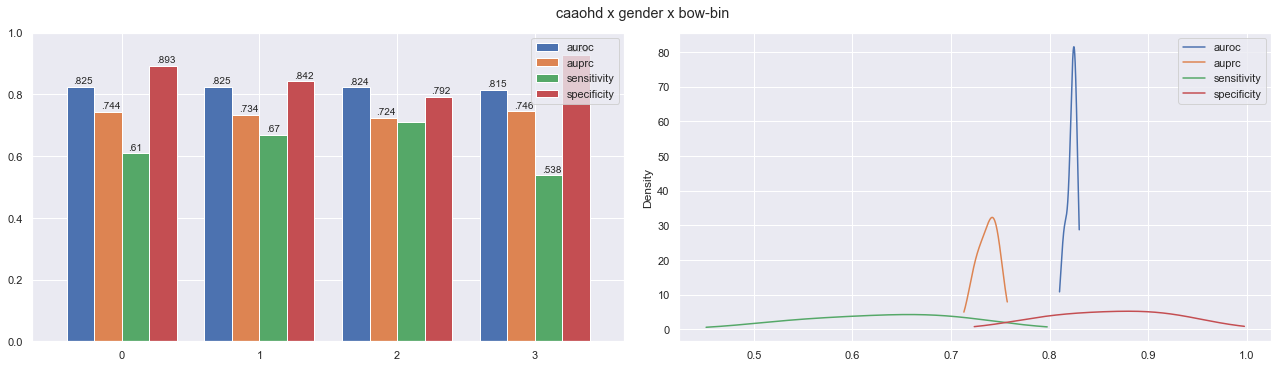

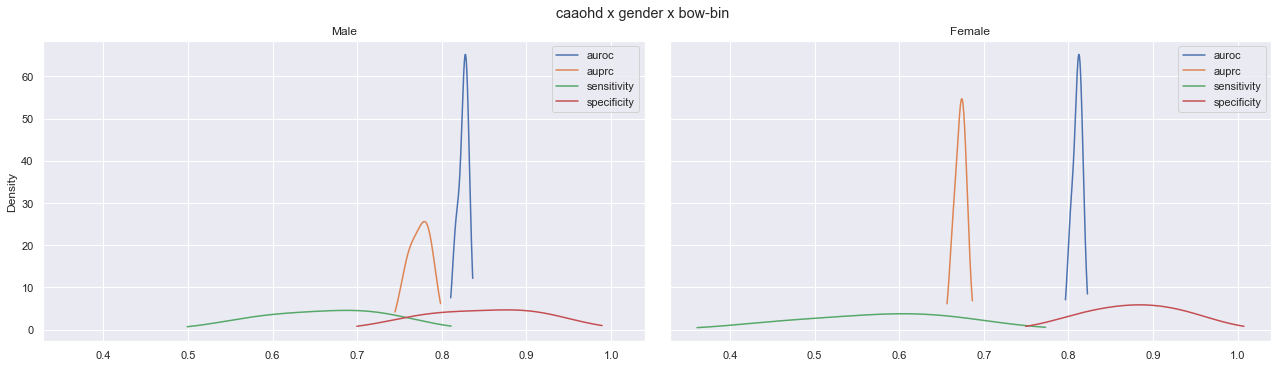

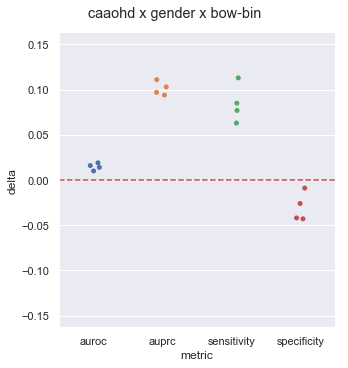

In [23]:
gender_analysis(input_path, dataset, model, output_path, tmp_path)

Train: 22034 | Test: 4919 | Val: 5509
Train: 22034 | Test: 4919 | Val: 5509
[reading cached features]
WHITE: 3552 | others: 1367
train/test set size: 22034/4919
Train: 22034 | Test: 4919 | Val: 5509
Train: 22034 | Test: 4919 | Val: 5509
[reading cached features]
NON-WHITE: 715 | others: 4204
train/test set size: 22034/4919


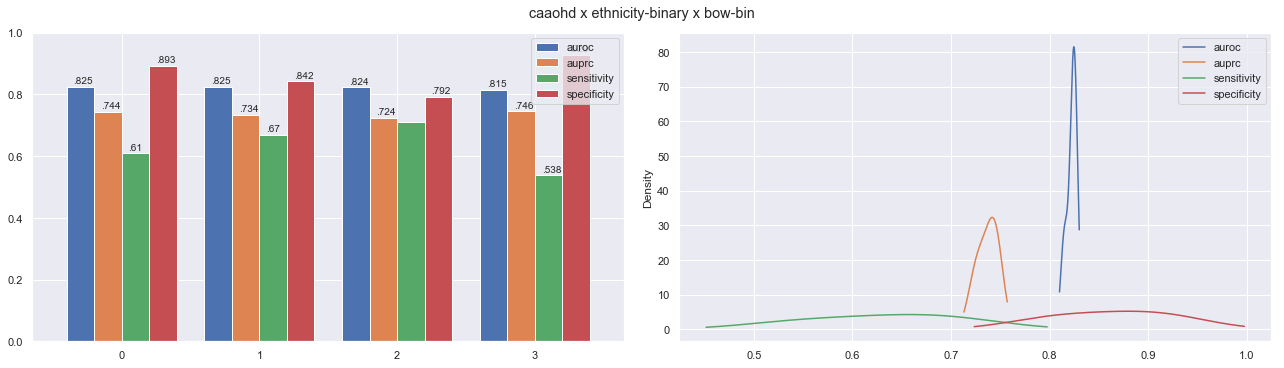

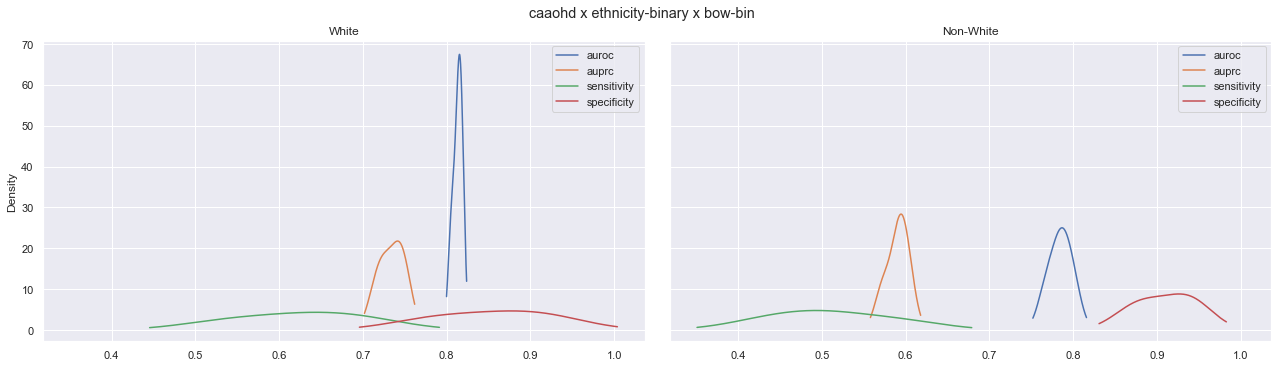

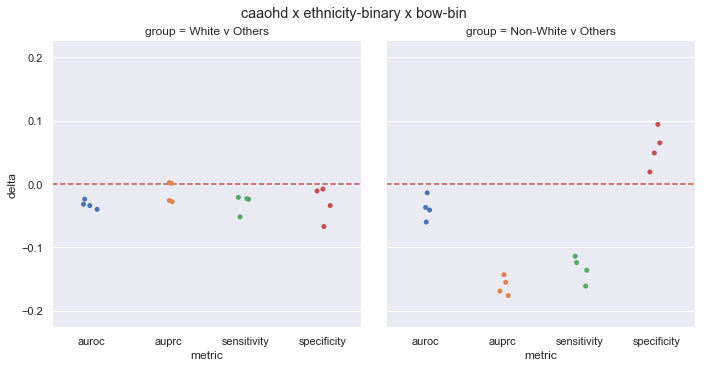

In [24]:
ethnicity_binary_analysis(input_path, dataset, model, output_path, tmp_path)

Train: 22034 | Test: 4919 | Val: 5509
Train: 22034 | Test: 4919 | Val: 5509
[reading cached features]
WHITE: 3552 | others: 1367
train/test set size: 22034/4919
Train: 22034 | Test: 4919 | Val: 5509
Train: 22034 | Test: 4919 | Val: 5509
[reading cached features]
BLACK: 451 | others: 4468
train/test set size: 22034/4919
Train: 22034 | Test: 4919 | Val: 5509
Train: 22034 | Test: 4919 | Val: 5509
[reading cached features]
ASIAN: 95 | others: 4824
train/test set size: 22034/4919
Train: 22034 | Test: 4919 | Val: 5509
Train: 22034 | Test: 4919 | Val: 5509
[reading cached features]
HISPANIC: 159 | others: 4760
train/test set size: 22034/4919


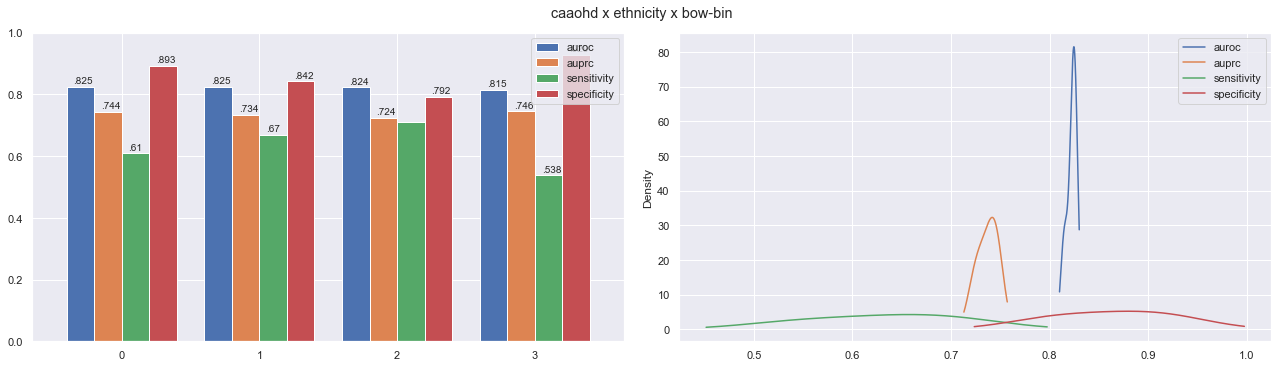

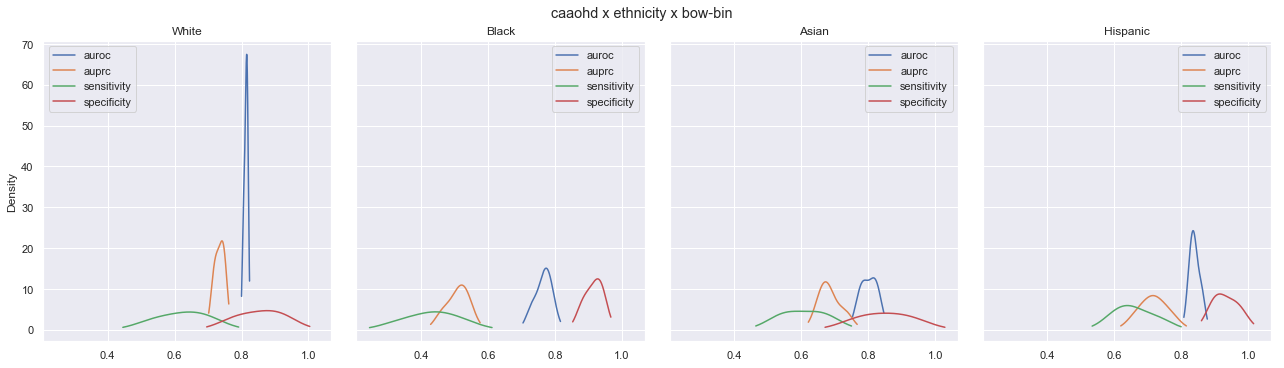

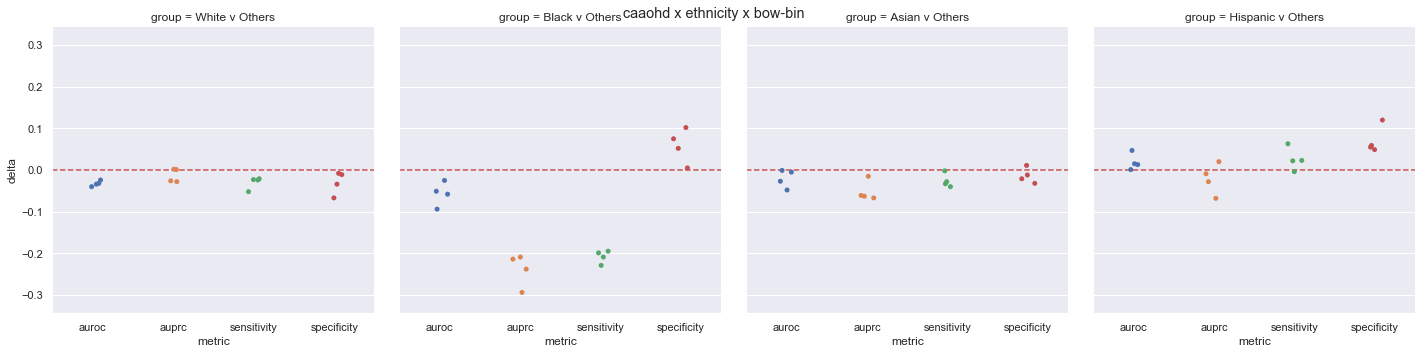

In [25]:
ethnicity_analysis(input_path, dataset, model, output_path, tmp_path)

In [ ]:
plot_cached_results(output_path, dataset, model)

In [ ]:
clear_cache(tmp_path)

In [30]:
def extract_features(feature_type, input_path, cache_path):
    X = read_cache(cache_path+"feats_{}".format(feature_type))
    if X:
        print("[reading cached features]")
        subject_ids, X_feats = X
    else:
        df = pd.read_csv(input_path+"patients.csv", sep="\t", header=0)
        subject_ids = list(df["SUBJECT_ID"])
        docs = list(df["TEXT"])
        X, word_vocab = vectorizer.docs2idx(docs)
        X_feats = get_features(X,len(word_vocab),feature_type)
        write_cache(cache_path+"feats_{}".format(feature_type), [subject_ids, X_feats])
    return subject_ids, X_feats

def read_dataset(path, dataset_name):
    df_patients = pd.read_csv(input_path+"patients.csv", sep="\t", header=0).drop(columns=["TEXT"])
    df_train = pd.read_csv("{}/{}_train.csv".format(path, dataset_name), sep="\t", header=0)
    df_test  = pd.read_csv("{}/{}_test.csv".format(path, dataset_name), sep="\t", header=0)
    df_val   = pd.read_csv("{}/{}_val.csv".format(path, dataset_name), sep="\t", header=0)
    #set indices
    df_patients.set_index("SUBJECT_ID", inplace=True)
    df_train.set_index("SUBJECT_ID", inplace=True)
    df_test.set_index("SUBJECT_ID", inplace=True)
    df_val.set_index("SUBJECT_ID", inplace=True)
    print("Train: {} | Test: {} | Val: {}".format(len(df_train),len(df_test),len(df_val)))
    df_train = df_train.join(df_patients, on="SUBJECT_ID", how="inner", lsuffix="N_").reset_index()
    df_test = df_test.join(df_patients, on="SUBJECT_ID", how="inner", lsuffix="N_").reset_index()
    df_val = df_val.join(df_patients, on="SUBJECT_ID", how="inner", lsuffix="N_").reset_index()
    print("Train: {} | Test: {} | Val: {}".format(len(df_train),len(df_test),len(df_val)))
    return df_train, df_test, df_val    

def vectorize(df_train, df_test, subject_ids, features, group_label, subgroup):
    df_test_G = df_test[df_test[group_label] == subgroup]
    df_test_O = df_test[df_test[group_label] != subgroup]
    
    print("{}: {} | others: {}".format(subgroup,len(df_test_G),len(df_test_O)))
        
    #vectorize labels
    train_Y = df_train["Y"]
    test_Y = df_test["Y"]
    test_Y_G = df_test_G["Y"]
    test_Y_O = df_test_O["Y"]       
    
    label_vocab = vectorizer.get_labels_vocab(train_Y+test_Y)
    train_Y,_ = vectorizer.label2idx(train_Y, label_vocab)
    test_Y,_ = vectorizer.label2idx(test_Y, label_vocab)
    test_Y_G,_ = vectorizer.label2idx(test_Y_G, label_vocab)
    test_Y_O,_ = vectorizer.label2idx(test_Y_O, label_vocab)
    
    train_idxs = [subject_ids.index(i) for i in list(df_train["SUBJECT_ID"])] 
    test_idxs = [subject_ids.index(i) for i in list(df_test["SUBJECT_ID"])] 
    test_idxs_G = [subject_ids.index(i) for i in list(df_test_G["SUBJECT_ID"])] 
    test_idxs_O = [subject_ids.index(i) for i in list(df_test_O["SUBJECT_ID"])] 
    
    train_feats = features[train_idxs, :]
    test_feats = features[test_idxs, :]
    test_feats_G = features[test_idxs_G, :]
    test_feats_O = features[test_idxs_O, :]
    
    return train_feats, train_Y, test_feats, test_Y, test_feats_G, test_Y_G, test_feats_O, test_Y_O, label_vocab


In [10]:
sids, X = extract_features(input_path, tmp_path, model)

In [11]:
tr, ts, val, = read_dataset(input_path, dataset)

Train: 1000 | Test: 1000 | Val: 1000
Train: 1000 | Test: 1000 | Val: 1000


In [24]:
train_feats, train_Y, test_feats, test_Y, test_feats_G, test_Y_G, test_feats_O, test_Y_O, label_vocab = vectorize(tr, ts, sids, X, "GENDER", "M")
train_feats


M: 592 | others: 408


<1000x155487 sparse matrix of type '<class 'numpy.float64'>'
	with 399690 stored elements in Compressed Sparse Row format>

AttributeError: 'list' object has no attribute 'shape'

In [17]:
feat_idxs

[555,
 3411,
 19176,
 14288,
 18692,
 13015,
 3309,
 2396,
 21526,
 3294,
 7385,
 18493,
 2553,
 14618,
 9808,
 11514,
 19143,
 21889,
 9232,
 2439,
 7371,
 10229,
 20404,
 14807,
 9458,
 411,
 1950,
 7698,
 1156,
 9678,
 12471,
 7635,
 1806,
 11538,
 20850,
 11146,
 17913,
 11975,
 17997,
 15820,
 24141,
 20313,
 14049,
 21470,
 20876,
 6402,
 1423,
 14962,
 17922,
 1804,
 17080,
 10633,
 10710,
 7035,
 625,
 2288,
 19509,
 584,
 2088,
 22686,
 9690,
 16787,
 13686,
 14686,
 11988,
 2896,
 10340,
 7092,
 6914,
 22874,
 13634,
 17558,
 15286,
 7757,
 14285,
 9688,
 16482,
 12250,
 21136,
 13524,
 7039,
 23533,
 6518,
 8765,
 6560,
 19370,
 9771,
 3480,
 14499,
 13817,
 2313,
 11944,
 19274,
 3270,
 1349,
 3407,
 14241,
 2872,
 6671,
 3652,
 19382,
 20135,
 20255,
 18715,
 6243,
 11950,
 5883,
 15147,
 2399,
 16178,
 3353,
 22951,
 21123,
 18732,
 303,
 21195,
 10176,
 8871,
 7713,
 20824,
 765,
 4308,
 11947,
 20986,
 8441,
 20648,
 12922,
 17242,
 6438,
 10075,
 2026,
 15557,
 922,
 8

In [19]:
print(sids[3411])

4579
